In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("Craigslist_Web_Scrape v0.13.csv", encoding = "utf-8")
labels = pd.read_csv("labels_cragislist.csv")
data = pd.concat([data, labels], axis = 1)

In [3]:
data

,Post ID,Post Title,Post URL,Post Image,Date,Item Cost,Post Text,Label
0,7552317764,Bike BMX 1978 Thunder Man 38,https://chicago.craigslist.org/nwc/bik/d/la-gr...,https://images.craigslist.org/00505_1hLBIEaYAe...,2022-11-16 20:20,$340,QR Code Link to This Post Bike BMX 1978 Th...,1
1,7552317764,Vintage Japanese Miyata Shinano 54cm,https://chicago.craigslist.org/chc/bik/d/chica...,https://images.craigslist.org/00B0B_2Q8Gm3Cqpn...,2022-11-16 20:19,$340,QR Code Link to This Post Great Japanese M...,1
2,7552317764,Bycicle- Bike,https://chicago.craigslist.org/nwi/bik/d/gary-...,https://images.craigslist.org/01111_2AjRUeghL6...,2022-11-16 20:16,$200,QR Code Link to This Post Vintage Columbia...,1
3,7552317764,Concord Pacer S/S Road,https://chicago.craigslist.org/chc/bik/d/chica...,https://images.craigslist.org/00E0E_2Sc84guSbe...,2022-11-16 20:03,$200,QR Code Link to This Post This bike has 10...,1
4,7552317764,Vintage Ladies 3 speed Regatta,https://chicago.craigslist.org/chc/bik/d/chica...,https://images.craigslist.org/00S0S_hDvavNURei...,2022-11-16 20:02,$130,"QR Code Link to This Post 19'' frame, 26' ...",1
...,...,...,...,...,...,...,...,...
2035,7552317764,Like New Sun EZ -3 SX Recumbent Bike,https://chicago.craigslist.org/nwc/bik/d/maren...,https://images.craigslist.org/00s0s_ekin7DFkB7...,2022-10-17 15:51,$320,QR Code Link to This Post $850 Selling a L...,0
2036,7552317764,Sun Recumbent Bike Blue,https://chicago.craigslist.org/nwc/bik/d/maren...,https://images.craigslist.org/00K0K_jgAyZnnKd3...,2022-10-17 15:51,$0,QR Code Link to This Post Selling a Like N...,0
2037,7552317764,Kestrel road racing triathlon bike,https://chicago.craigslist.org/chc/bik/d/chica...,https://images.craigslist.org/00E0E_bz6xNgHXb9...,2022-10-17 14:43,$400,QR Code Link to This Post Kestrel road rac...,1
2038,7552317764,"26"" USA Made HUFFY 10 Speed BIKE BICYCLE",https://chicago.craigslist.org/wcl/bik/d/lomba...,https://images.craigslist.org/00e0e_4ChTtYq0ld...,2022-10-17 13:56,$400,QR Code Link to This Post A really mnice H...,1


In [4]:
data_deduped = data.drop_duplicates(subset=['Post Title'], keep=False)

In [5]:
data_deduped=data_deduped.drop(["Post ID"], axis=1)

In [6]:
data_deduped['Post Text'] = data_deduped['Post Text'].str[30:]

In [7]:
data_deduped['Post Text'].iloc[6]

'1970s quality cruiser bike 10 speed made in Japan Has some rust spots as you would expect from over 40 years old bicycle but mechanically it is in great condition. Bike shifts good through all the gears. Breaks work good, tires are good and hold air. Bike rides good. '

In [8]:
data_deduped['Item Cost'] = data_deduped['Item Cost'].replace('[\$,]', '', regex=True).astype(float)

In [9]:
data_deduped['Label'].value_counts()

1    1511
0     151
Name: Label, dtype: int64

In [10]:
# Importing libraries 
import os
from gensim import models
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
embeddings_index = {}
f = open('C:/BAIM - Purdue/MGMT590AUD - Analyzing Unstructured Data/Project/glove.6B.50d.txt',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [12]:
# Cleaning and Pre Processing text
import re

def clean_numbers(text):
    text = re.sub('[0-9]{5,}', '#####', text)
    text = re.sub('[0-9]{4}', '####', text)
    text = re.sub('[0-9]{3}', '###', text)
    text = re.sub('[0-9]{2}', '##', text)
    return text

def clean_text(text):
    text = clean_numbers(text)
    text = str(text)

    for punct in "/-'":
        text = text.replace(punct, ' ')
    for punct in '&':
        text = text.replace(punct, f' {punct} ')
    for punct in '?!.,"$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        text = text.replace(punct, '')

    text = text.lower()
    return text

In [13]:
from numpy import zeros
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Embedding

In [14]:
data_deduped["processed_data"] = data_deduped['Post Text'].progress_apply(lambda x: clean_text(x))
# train_df["length"] = data_deduped['Post Text'].progress_apply(lambda x: len(x.split()))

100%|███████████████████████████████████████████████████████████████████████████| 1662/1662 [00:00<00:00, 15856.26it/s]


In [15]:
docs = data_deduped["processed_data"].values

In [16]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)
# pad documents to a max length of 150 
max_length = 150
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

[[3, 282, 3999, 29, 16, 6, 2, 511, 90, 21, 1608, 418, 102, 52, 35], [92, 2035, 4000, 3, 1071, 364, 34, 244, 16], [13, 3, 30, 14, 11, 18, 125, 1, 1, 60, 5, 39, 10, 7, 1459, 6, 236, 38, 121, 38], [11, 4001, 419, 79, 12, 18, 86, 4002, 3, 7, 8, 74, 16, 10, 7, 85, 8, 2, 295, 147, 6, 236, 38, 86, 38, 245, 378, 13, 3, 7, 125, 1, 60, 5, 39], [2, 3, 30, 11, 79, 12, 4003, 7, 8, 67, 12, 16, 142, 1, 125, 21], [6, 56, 7, 4, 954, 4004, 8, 4005, 384, 2, 3, 7, 8, 34, 16, 10, 26, 103, 512, 2036, 109, 209, 4006, 99, 111, 466, 9, 2, 3, 10, 26, 60, 5, 39, 83, 1, 25, 98, 32, 548, 1, 27, 316, 31, 103, 467, 18, 32, 8, 34, 166, 9, 774, 15, 468, 529, 142, 171, 1, 292, 155, 2037, 2, 11, 54, 168, 70, 135, 21, 42, 4, 143, 14, 41, 1460, 10, 30, 2038, 1072, 8, 2, 25, 4, 1227, 3, 54, 70, 55, 6, 143, 1788, 439, 68, 1143, 396, 116, 6], [26, 278, 219, 3, 14, 85, 8, 854, 30, 65, 283, 1144, 42, 23, 296, 2913, 46, 164, 156, 178, 37, 45, 1789, 10, 7, 8, 34, 16, 3, 309, 29, 469, 27, 2, 195, 898, 224, 29, 18, 32, 29, 1, 414,

In [17]:
labels = data_deduped["Label"].values

In [18]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
# Create Train/Test data
from sklearn.model_selection import train_test_split

X_train_SMOTE, X_test, y_train_SMOTE, y_test = train_test_split(padded_docs,
                               labels,stratify=labels, random_state=0)

In [20]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=0)
X_train, y_train = smt.fit_resample(X_train_SMOTE, y_train_SMOTE)

In [21]:
# from sklearn.model_selection import GridSearchCV
# search = GridSearchCV(estimator=model, param_grid=params,
#                               cv=5, verbose=1)
# search_result = search.fit(X_train, y_train)

In [22]:
# test_accuracy = search.score(X_test, y_test)

In [23]:
# search.best_params_

In [24]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)
# for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [25]:
model_new = Sequential([
      keras.layers.Embedding(vocab_size, 50, weights=[embedding_matrix], 
                                 input_length=max_length, trainable=True),
      keras.layers.Conv1D(32, 3, activation='relu'),
      keras.layers.GlobalMaxPooling1D(),
#       keras.layers.LSTM(100),
#         keras.layers.Conv1D(64, 3, activation='relu'),
      keras.layers.Dense(10, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])

In [26]:
model_new.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           369250    
                                                                 
 conv1d (Conv1D)             (None, 148, 32)           4832      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 374,423
Trainable params: 374,423
Non-trainable params: 0
__________________________________________________

In [27]:
model_new.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model_new.fit(X_train,y_train, epochs=20, validation_data=(X_test,y_test),
#                     callbacks =[early_stop],
                    batch_size=256)

Epoch 1/20
9/9 [==============================] - 2s 107ms/step - loss: 0.7099 - accuracy: 0.5150 - val_loss: 0.6396 - val_accuracy: 0.6803
Epoch 2/20
9/9 [==============================] - 1s 62ms/step - loss: 0.6449 - accuracy: 0.6584 - val_loss: 0.6595 - val_accuracy: 0.6370
Epoch 3/20
9/9 [==============================] - 1s 63ms/step - loss: 0.6023 - accuracy: 0.7286 - val_loss: 0.6301 - val_accuracy: 0.6995
Epoch 4/20
9/9 [==============================] - 1s 63ms/step - loss: 0.5631 - accuracy: 0.7864 - val_loss: 0.6768 - val_accuracy: 0.5817
Epoch 5/20
9/9 [==============================] - 1s 62ms/step - loss: 0.5240 - accuracy: 0.8186 - val_loss: 0.6593 - val_accuracy: 0.6154
Epoch 6/20
9/9 [==============================] - 1s 60ms/step - loss: 0.4849 - accuracy: 0.8504 - val_loss: 0.5948 - val_accuracy: 0.7115
Epoch 7/20
9/9 [==============================] - 1s 61ms/step - loss: 0.4433 - accuracy: 0.8711 - val_loss: 0.5228 - val_accuracy: 0.7692
Epoch 8/20
9/9 [==========

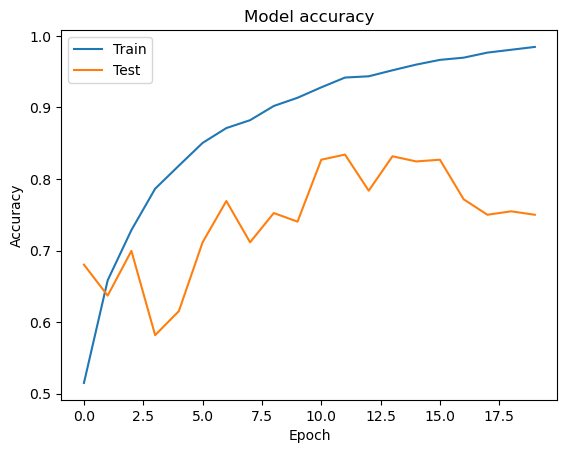

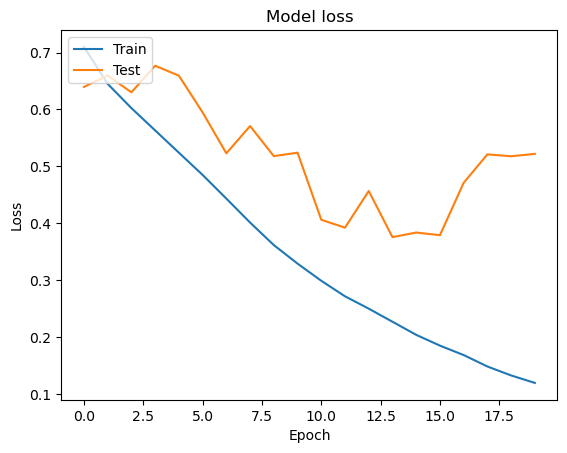

In [28]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
prob_test = model_new.predict(X_test)
y_pred_1 = []
for i in range(len(prob_test)):
    if prob_test[i][0] > 0.5:
        y_pred_1.append(1)
    else:
        y_pred_1.append(0)
        
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
def c_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_sc))
    return acc_sc

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

13/13 [==============================] - 0s 3ms/step


Classification Report
              precision    recall  f1-score   support

           0       0.23      0.74      0.35        38
           1       0.97      0.75      0.85       378

    accuracy                           0.75       416
   macro avg       0.60      0.74      0.60       416
weighted avg       0.90      0.75      0.80       416

Accuracy : 0.75


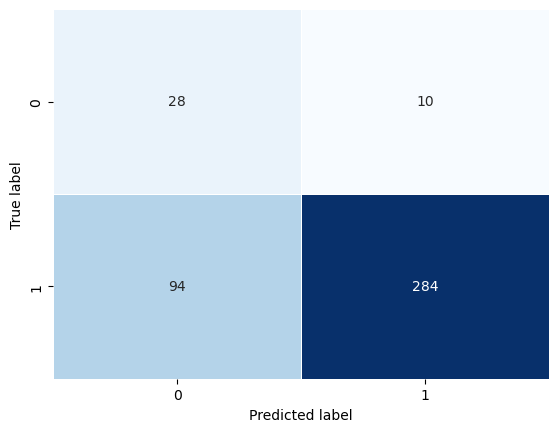

In [30]:
c_report(y_test, y_pred_1)
plot_confusion_matrix(y_test, y_pred_1)

In [31]:
data_test = pd.read_csv("C:\\BAIM - Purdue\\MGMT590AUD - Analyzing Unstructured Data\\Project\\Cincinnati - test data.csv")

In [32]:
data_test['Post Text'] = data_test['Post Text'].str[30:]

In [33]:
data_test['Item Cost'] = data_test['Item Cost'].replace('[\$,]', '', regex=True).astype(float)

In [34]:
data_test

,Post ID,Post Title,Post URL,Post Image,label_text,y_true_img,y_pred_img,Date,Item Cost,Post Text
0,7559399758,"29"" CYPRESS GIANT GAS BICYCLE/10 GAUGE RIMS/PU...",https://cincinnati.craigslist.org/bik/d/alexan...,https://images.craigslist.org/00a0a_jgsLYMb87Y...,NaN,1,0,########,875.0,Cypress Giant GAS Bicycle. 10 Gauge Spoke Rims...
1,7559029505,Schwinn Mesa Runner,https://cincinnati.craigslist.org/bik/d/ft-mit...,https://images.craigslist.org/00303_iKcZt7NnFQ...,NaN,1,0,########,875.0,"new 17"" Schwinn Mesa Runner, has new tires an..."
2,7559036031,Kulana tandem,https://cincinnati.craigslist.org/bik/d/ft-mit...,https://images.craigslist.org/00909_5vDjN5r5Fo...,NaN,1,0,########,100.0,"new Kulana tandem, bike is in perfect conditi..."
3,7558857843,Schwinn Electric Bike Healy Ridge Like New.,https://cincinnati.craigslist.org/bik/d/hebron...,https://images.craigslist.org/00c0c_2n3RzMSqwr...,NaN,1,0,########,100.0,"r ridden,perfect.26 inch wheels.18 speed.Up to..."
4,7565226108,2019 Giant Liv Enchant kids 24 in like new,https://cincinnati.craigslist.org/bik/d/mainev...,https://images.craigslist.org/01717_jpT6HqwhxW...,NaN,1,0,########,150.0,"bike is like a new one, they are $350 and up ..."
...,...,...,...,...,...,...,...,...,...,...
657,7537699999,Schwinn Sidewinder Comfort Hybrid Bicycle,https://cincinnati.craigslist.org/bik/d/cincin...,https://images.craigslist.org/00m0m_kBdKhIC62y...,NaN,1,0,########,4100.0,inn Skyliner comfort/hybrid bicycle with tires...
658,7548893547,Kent Avalon Confort Series 26â€,https://cincinnati.craigslist.org/bik/d/cincin...,https://images.craigslist.org/01313_9PELA5jciv...,NaN,1,0,########,600.0,ing front wheel. Other than that bike and driv...
659,7548891770,Mongoose 26â€ Menâ€™s Mountain Bike,https://cincinnati.craigslist.org/bik/d/cincin...,https://images.craigslist.org/00U0U_c2DZHyFO5y...,NaN,1,0,########,600.0,needs a new shifter cable. Also needs a brake...
660,7548737351,Windsor Bike,https://cincinnati.craigslist.org/bik/d/west-c...,https://images.craigslist.org/00P0P_inN6Yt3rIU...,NaN,1,0,########,800.0,"peed, Excellent condition, 27"" wheels Schwinn ..."


In [35]:
data_test['y_true_img'].value_counts()

1    621
0     41
Name: y_true_img, dtype: int64

In [36]:
data_test["processed_data"] = data_test['Post Text'].progress_apply(lambda x: clean_text(x))
# train_df["length"] = data_deduped['Post Text'].progress_apply(lambda x: len(x.split()))

100%|█████████████████████████████████████████████████████████████████████████████| 662/662 [00:00<00:00, 20805.11it/s]


In [37]:
docs_test = data_test["processed_data"].values

In [38]:
# prepare tokenizer
# t = Tokenizer()
# t.fit_on_texts(docs_test)
# vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs_test)
print(encoded_docs)
# pad documents to a max length of 150 
max_length = 150
padded_docs_new = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

[[6877, 170, 1378, 37, 1598, 1061, 97, 314, 563, 110, 629, 801, 97, 12, 4665, 2666, 5261, 1438, 18, 3, 30, 8, 97, 1, 18, 34, 24, 1378, 1376, 7, 79, 12, 19, 37, 168, 30, 518, 2156, 109, 23, 54, 518, 2233, 1, 20, 322, 2233, 518, 2156, 7, 735, 318, 278, 37, 7, 1187, 351, 34, 651, 278, 37, 9, 12, 1378, 1376, 132, 261, 352, 637, 222, 464, 1378, 8, 2539, 1235, 261, 102, 2353, 72, 128, 105, 134, 8, 590, 44, 5978, 44, 1837, 8, 236, 52, 35], [12, 43, 1829, 2431, 30, 12, 18, 1, 186, 138, 169, 50, 33, 400, 518, 36, 3621, 14, 1297, 181, 279, 1, 19, 11, 157, 6, 213, 38, 64, 5, 38, 121], [12, 1071, 3, 7, 8, 157, 16, 60, 6, 23, 1, 4, 2295, 5, 201, 6, 4, 39, 226, 4, 34, 741, 6, 80, 862, 365], [425, 81, 33, 5, 1529, 1025, 381, 52], [3, 7, 67, 4, 12, 84, 285, 32, 1, 21, 13, 1162, 380, 202, 1706, 57, 296, 226, 4, 34, 741, 1112, 30, 699, 239, 1, 2, 18, 32, 117, 67, 12, 168, 168, 30, 4, 142, 50, 11], [26, 2120, 3, 977, 181, 5, 135, 21, 181, 5, 108, 2, 409, 15, 2, 62, 9, 4, 1264, 1185, 977, 47, 81, 5, 87, 2

In [39]:
len(t.word_index)

7384

In [40]:
vocab_size

7385

In [41]:
labels_test = data_test["y_true_img"].values

In [42]:
prob_test_new = model_new.predict(padded_docs_new)
y_pred_1_new = []
for i in range(len(prob_test_new)):
    if prob_test_new[i][0] > 0.5:
        y_pred_1_new.append(1)
    else:
        y_pred_1_new.append(0)
        
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
def c_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    acc_sc = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_sc))
    return acc_sc

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

21/21 [==============================] - 0s 2ms/step


Classification Report
              precision    recall  f1-score   support

           0       0.12      0.49      0.19        41
           1       0.96      0.76      0.85       621

    accuracy                           0.74       662
   macro avg       0.54      0.62      0.52       662
weighted avg       0.91      0.74      0.81       662

Accuracy : 0.7447129909365559


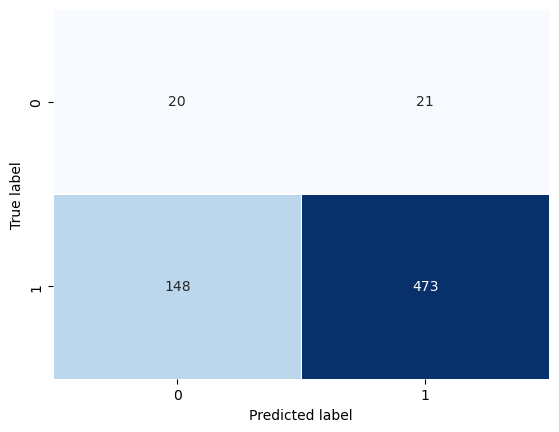

In [43]:
c_report(labels_test, y_pred_1_new)
plot_confusion_matrix(labels_test, y_pred_1_new)

In [44]:
data_test['text_pred'] = prob_test_new

In [45]:
prob_test_new

array([[0.2077895 ],
       [0.9754896 ],
       [0.71583205],
       [0.423715  ],
       [0.89341635],
       [0.21156396],
       [0.5219065 ],
       [0.28088856],
       [0.8101045 ],
       [0.9426332 ],
       [0.6621397 ],
       [0.9238251 ],
       [0.4533082 ],
       [0.63809556],
       [0.8500729 ],
       [0.36260566],
       [0.6016104 ],
       [0.58122694],
       [0.7427384 ],
       [0.93591815],
       [0.81330407],
       [0.05934835],
       [0.80302936],
       [0.9037839 ],
       [0.89852405],
       [0.21482524],
       [0.570086  ],
       [0.60386604],
       [0.3455972 ],
       [0.9796341 ],
       [0.7805203 ],
       [0.9678417 ],
       [0.4894888 ],
       [0.67092067],
       [0.9202181 ],
       [0.89466256],
       [0.4894888 ],
       [0.86706877],
       [0.90483636],
       [0.916792  ],
       [0.73134106],
       [0.48040536],
       [0.7691546 ],
       [0.9657893 ],
       [0.5959536 ],
       [0.9907237 ],
       [0.47061455],
       [0.894

In [46]:
# pd.DataFrame(y_pred_1_new).to_csv("Test_Data_PRED_Labels_CNN v0.1.csv")